# Аспектный анализ тональности текстов: используем возможности fasttext

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone !git clone https://github.com/wegolev/aspect_sentiment_SentiRuEval-2015.git
# pip install -r aspect_sentiment_SentiRuEval-2015/requirements.txt
# import sys; sys.path.append('./aspect_sentiment_SentiRuEval-2015')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [3]:
# Установка "нормальной" подсветки для темного фона
from ipymarkup.palette import material, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

colors = BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

for c in colors:
    color_name = c.name[0].capitalize() + c.name[1:]
    c.background = material(color_name, '900')

## BIO-тэггинг для обучения модели

In [4]:
from dlnlputils.sentiment_utils import parse_xml_aspect, show_markup,prepare_data, generate_markup

In [5]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [6]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = 'datasets/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/SentiRuEval_car_markup_test.xml'

In [7]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

In [8]:
len(training_data), len(test_data)

(2210, 1922)

In [9]:
test_recipe, test_tags = training_data[400]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

## Статистика по тэгам

In [10]:
from collections import Counter
from collections import defaultdict

def form_vocabulary_and_tagset(words_w_tags):
    dictionary = defaultdict(Counter)
    for words,tags in words_w_tags: 
        for word, tag in zip(words, tags):
            dictionary[tag].update([word])      
    return dictionary, set(dictionary.keys()) 

In [11]:
word_counter, labels = form_vocabulary_and_tagset(training_data)

In [12]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

478	in B-Comfort
200	in I-Whole
584	in B-Driveability
284	in I-Comfort
97	in I-Costs
464	in B-Reliability
300	in I-Reliability
189	in B-Appearance
236	in B-Whole
103	in I-Appearance
60	in B-Safety
393	in I-Driveability
4933	in Other
49	in I-Safety
169	in B-Costs


In [13]:
word_counter['I-Comfort'].most_common()#[-1]

[('в', 29),
 ('салоне', 17),
 ('места', 15),
 ('сиденья', 14),
 ('багажник', 12),
 ('сидений', 10),
 ('салона', 9),
 ('на', 8),
 ('для', 6),
 ('сидения', 5),
 ('багажника', 5),
 ('с', 5),
 ('и', 5),
 ('комплектации', 5),
 ('не', 5),
 ('автомобиля', 4),
 ('задние', 4),
 ('управления', 4),
 ('салон', 4),
 ('автомобиле', 3),
 ('тесно', 3),
 ('отделение', 3),
 ('передач', 3),
 ('фар', 3),
 ('стекло', 3),
 ('хватает', 3),
 ('приборов', 3),
 ('ног', 3),
 ('двери', 2),
 ('пластик', 2),
 ('авто', 2),
 ('машины', 2),
 ('колонка', 2),
 ('все', 2),
 ('пассажиров', 2),
 ('панели', 2),
 ('диване', 2),
 ('обслуживании', 2),
 ('заднем', 2),
 ('водителя', 2),
 ('от', 2),
 ('панель', 2),
 ('эксплуатации', 2),
 ('универсал', 2),
 ('-контроль', 2),
 ('передних', 2),
 ('потолок', 2),
 ('достаточно', 2),
 ('магнитолу', 2),
 ('удобно', 2),
 ('системы', 2),
 ('сидениях', 2),
 ('арок', 2),
 ('chery', 2),
 ('qq6', 2),
 ('1', 2),
 ('.1', 2),
 ('стучит', 2),
 ('безопасности', 2),
 ('"космо"', 1),
 ('руссифициров

In [14]:
class TagConverter():
    def __init__(self, tags):
        self.idx_to_tag  = sorted(tags)
        self.tag_to_idx  = {tag:idx for idx,tag in enumerate(self.idx_to_tag)}
        
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i] for i in indices]

In [15]:
tag_converter = TagConverter(labels)

In [16]:
test_recipe, test_tags = training_data[321]

# оригинал
text, spans = generate_markup(test_recipe, test_tags) 
show_markup(text, spans)

# кодируем только тэги:
encoded_tags = tag_converter.tags_to_index(test_tags)
print(encoded_tags)
print()

# декодируем тэги:
decoded_tags = tag_converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(test_recipe, decoded_tags) 
show_markup(text, spans)

tensor([ 6, 14, 14, 14])



## fastText: забираем функции embedding слоя

In [17]:
import zipfile
import gensim
import wget

In [18]:
# model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
# wget.download(model_url)

#### модель fasttext: редкие и  выдуманные слова

In [19]:
# with zipfile.ZipFile('187.zip', 'r') as zip_ref:
#     zip_ref.extractall('datasets/187/')
    # Colab:
    # zip_ref.extractall('./stepik-dl-nlp/datasets/187/')

In [20]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

# Colab:
# w2v_model = gensim.models.KeyedVectors.load('./stepik-dl-nlp/datasets/187/model.model')

In [21]:
words = ['тачаночка', 'двиганчик', 'ковервертолет']

for word in words:
    print(word)

    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')

тачаночка


: 

Создадим конвертер слов в векторы fasttext:

In [ ]:
class WordConverter:
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model

    def convert(self, words):
        embeddings = [self.w2v_model.get_vector(word) for word in words]
        embeddings = torch.FloatTensor(embeddings)
        return embeddings

In [ ]:
word_converter = WordConverter(w2v_model)

words,_ = training_data[333]
vectors = word_converter.convert(words)

vectors.shape

/tmp/ipykernel_3525/1159978501.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embeddings = torch.FloatTensor(embeddings)


torch.Size([27, 300])

##  LSTM: теперь без embedding слоя

In [ ]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
TAGSET_SIZE   = len(tag_converter.tag_to_idx)

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, word_converter):
        super(LSTMTagger, self).__init__()
        tagset_size = len(tag_converter.tag_to_idx)
        
        self.word_converter = word_converter
        self.lstm           = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag     = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, words):
        embeds      = self.word_converter.convert(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)  
        return tags_pred

In [ ]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

97	in I-Costs
169	in B-Costs
284	in I-Comfort
200	in I-Whole
60	in B-Safety
189	in B-Appearance
300	in I-Reliability
4933	in Other
103	in I-Appearance
478	in B-Comfort
236	in B-Whole
49	in I-Safety
584	in B-Driveability
393	in I-Driveability
464	in B-Reliability


In [ ]:
from collections import Counter
from pprint import pprint

tag_counter = Counter()
for label in labels:
    tag_counter[label] = len(word_counter[label])
        
pprint(tag_counter.most_common())


class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = tag_converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))

class_weights /= class_divs

print(class_weights.detach())

[('Other', 4933),
 ('B-Driveability', 584),
 ('B-Comfort', 478),
 ('B-Reliability', 464),
 ('I-Driveability', 393),
 ('I-Reliability', 300),
 ('I-Comfort', 284),
 ('B-Whole', 236),
 ('I-Whole', 200),
 ('B-Appearance', 189),
 ('B-Costs', 169),
 ('I-Appearance', 103),
 ('I-Costs', 97),
 ('B-Safety', 60),
 ('I-Safety', 49)]
tensor([ 26.7865,  10.5913,  29.9565,   8.6689,  10.9109,  84.3775,  21.4519,
         49.1519,  17.8262,  52.1923,  12.8821,  16.8755, 103.3194,  25.3133,
          1.0263])


In [ ]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE, word_converter)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

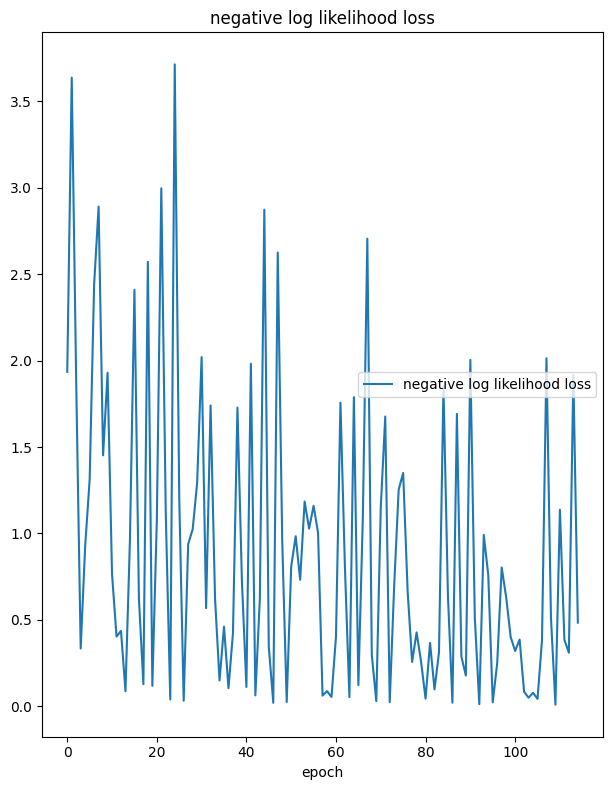

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.009, max:    3.714, cur:    0.484)


In [ ]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(recipe) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            liveplot.update({'negative log likelihood loss': loss.detach()})
            liveplot.draw()   

In [ ]:
def predict_tags(model, recipe):
    encoded_tags   = model.predict_tags(recipe)      # предсказанные тэги (номера)
    decoded_tags   = tag_converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    return decoded_tags

In [ ]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


In [ ]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [ ]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, sentence)
    y_true += tags

In [ ]:
ordered_tags = [
 'Other',
 'B-Whole',
 'I-Whole',
 'B-Driveability',
 'I-Driveability',
 'B-Appearance',
 'I-Appearance',
 'B-Reliability',
 'I-Reliability',
 'B-Comfort',
 'I-Comfort',
 'B-Costs',
 'I-Costs',
 'B-Safety',
 'I-Safety']

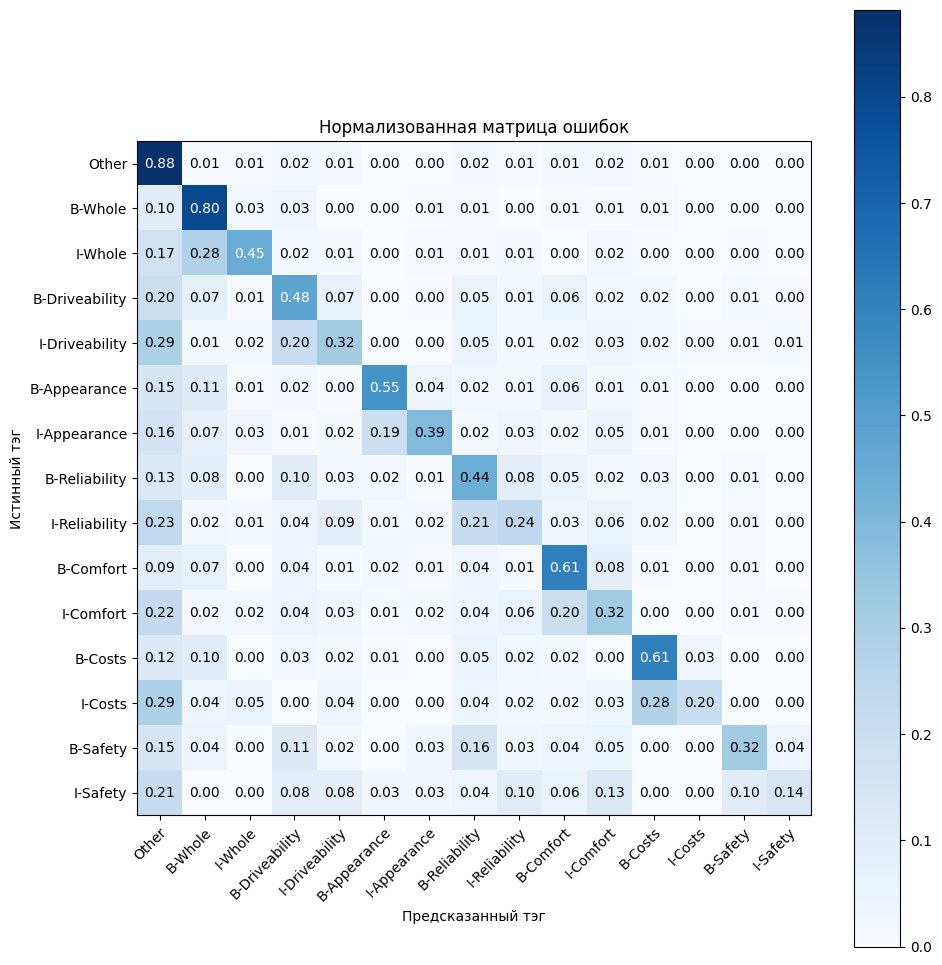

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True, 
                      title='Нормализованная матрица ошибок')
plt.show()